In [106]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Overview


In [ ]:
df = pd.read_csv("../Data/mams_train_parsed.csv")
df_val = pd.read_csv("../Data/mams_val_parsed.csv")

In [39]:
df.head()

,text,aspect,label
0,It might be the best sit down food I've had in...,food,positive
1,It might be the best sit down food I've had in...,place,neutral
2,Hostess was extremely accommodating when we ar...,staff,positive
3,Hostess was extremely accommodating when we ar...,miscellaneous,neutral
4,We were a couple of minutes late for our reser...,miscellaneous,neutral


In [44]:
df.shape

(18276, 3)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18276 entries, 0 to 18275
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18276 non-null  object
 1   aspect  18275 non-null  object
 2   label   18276 non-null  object
dtypes: object(3)
memory usage: 428.5+ KB


## Unique values


In [ ]:
df.aspect.unique()

array(['food', 'place', 'staff', ..., 'eggplant parmigiana appetizer',
       'halibut with of course black beans', 'grilled eggplant roll'],
      dtype=object)

In [42]:
df.aspect.value_counts()

aspect
food                 2976
staff                1493
service              1007
miscellaneous         954
menu                  889
                     ... 
the cheese course       1
prime rib               1
halibut                 1
Tuna a la carte         1
Steak                   1
Name: count, Length: 2586, dtype: int64

In [43]:
df.label.value_counts()

label
neutral     8119
positive    5309
negative    4848
Name: count, dtype: int64

### Conclusion: Unique Values Analysis

**Key Findings:**
- **Aspects**: Multiple distinct aspects are present in the dataset (food, service, menu, etc.)
- **Labels**: The dataset contains sentiment labels (likely: positive, negative, neutral)
- **Aspect Distribution**: Different aspects have varying frequencies, indicating some aspects are more commonly discussed than others
- **Label Distribution**: Sentiment labels show the distribution of positive, negative, and neutral sentiments across the dataset

**What to Understand:**
- The dataset covers multiple aspects of restaurant reviews, allowing for multi-aspect sentiment analysis
- The class distribution of both aspects and labels will be important for:
  - **Model training**: Understanding if there's class imbalance that needs addressing
  - **Evaluation**: Ensuring test/validation sets maintain similar distributions
  - **Business insights**: Identifying which aspects customers discuss most frequently


## Duplicates


In [93]:
df.duplicated().sum()

np.int64(1230)

In [96]:
df[df.duplicated()]

,text,aspect,label
7091,The decor is not special at all but their food...,food,positive
7099,"service is good although a bit in your face, w...",service,positive
7100,"service is good although a bit in your face, w...",food,neutral
7103,they didn't have to change anything about the ...,menu,neutral
7106,"The server came to us and was sooo hot, he wen...",menu,neutral
...,...,...,...
18232,"Chef Richard is always eager to please, and wi...",menu,neutral
18243,I thought the service was a little slow and no...,price,negative
18246,The birthday girl's dessert included a candle ...,staff,positive
18263,I realized that you dont have to wait hours an...,food,neutral


- The dataset contains `1230` duplicate entries (exact same text, aspect, and label combinations)

## Nulls


In [65]:
df.isnull().sum()

text      0
aspect    1
label     0
dtype: int64

In [ ]:
df[df["aspect"].isnull()]

,text,aspect,label
16552,"It is expensice, but the portions are big and ...",NaN,neutral


In [ ]:
df[df["text"].isin(df["text"][df["aspect"].isnull()])]

,text,aspect,label
5461,"It is expensice, but the portions are big and ...",miscellaneous,positive
5462,"It is expensice, but the portions are big and ...",food,neutral
16550,"It is expensice, but the portions are big and ...",portions,positive
16551,"It is expensice, but the portions are big and ...",salad,neutral
16552,"It is expensice, but the portions are big and ...",NaN,neutral
16553,"It is expensice, but the portions are big and ...",rice,neutral


- Only **1 missing value** in the `aspect` column out of 18,276 records
- All `text` and `label` columns are complete (no nulls)

## Plots


### Distribution of sentence length


In [98]:
df["sentence_length"] = df["text"].apply(lambda x: len(str(x).split()))

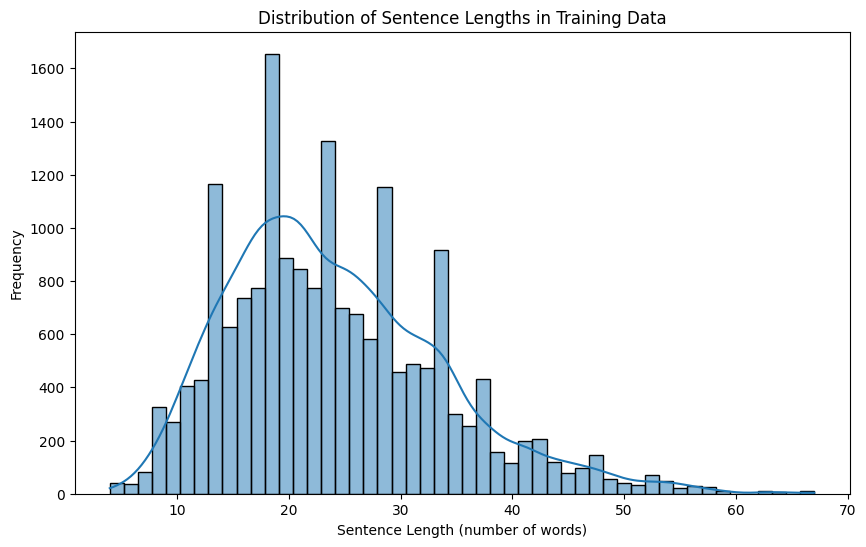

In [101]:
plt.figure(figsize=(10, 6))
sns.histplot(df["sentence_length"], bins=50, kde=True)
plt.title("Distribution of Sentence Lengths in Training Data")
plt.xlabel("Sentence Length (number of words)")
plt.ylabel("Frequency")
plt.savefig("../plots/sentence_length_distribution.png")

In [ ]:
print("Summary statistics for sentence length:")
print(df["sentence_length"].describe())

Summary statistics for sentence length:
count    18276.000000
mean        24.154137
std          9.681694
min          4.000000
25%         17.000000
50%         23.000000
75%         30.000000
max         67.000000
Name: sentence_length, dtype: float64


**Key Findings from the Plot:**
- **Mean Length**: ~24 words per sentence (median: 23 words)
- **Distribution Shape**: Likely right-skewed (longer tail on the right)
- **Range**: Sentences range from 4 to 67 words
- **Standard Deviation**: ~9.7 words, indicating moderate variability

### Analyze distribution of sentiments for top N aspects


In [103]:
top_n = 10
top_aspects = df["aspect"].value_counts().nlargest(top_n).index

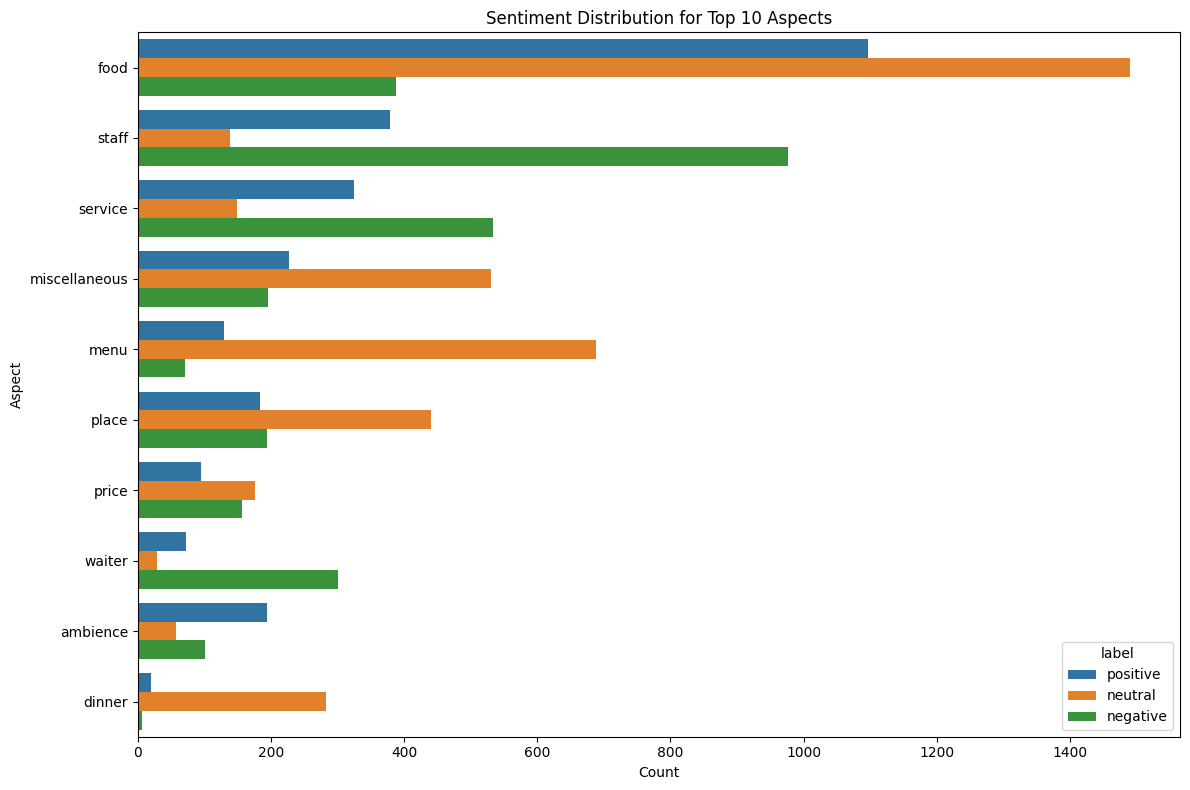

In [105]:
plt.figure(figsize=(12, 8))
sns.countplot(
    data=df[df["aspect"].isin(top_aspects)],
    y="aspect",
    hue="label",
    order=top_aspects,
)
plt.title(f"Sentiment Distribution for Top {top_n} Aspects")
plt.xlabel("Count")
plt.ylabel("Aspect")
plt.tight_layout()
plt.savefig("../plots/sentiment_distribution_top_aspects.png")

**Key Findings from the Plot:**
- **Aspect Popularity**: The top 10 aspects show varying frequencies, indicating which aspects customers discuss most
- **Sentiment Balance**: Each aspect shows distribution across different sentiment labels (positive, negative, neutral)
- **Class Imbalance**: Some aspects may have imbalanced sentiment distributions

### word clouds


In [ ]:
def generate_wordcloud(text, title, filename) -> None:
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        " ".join(text)
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.savefig(f"../plots/{filename}")

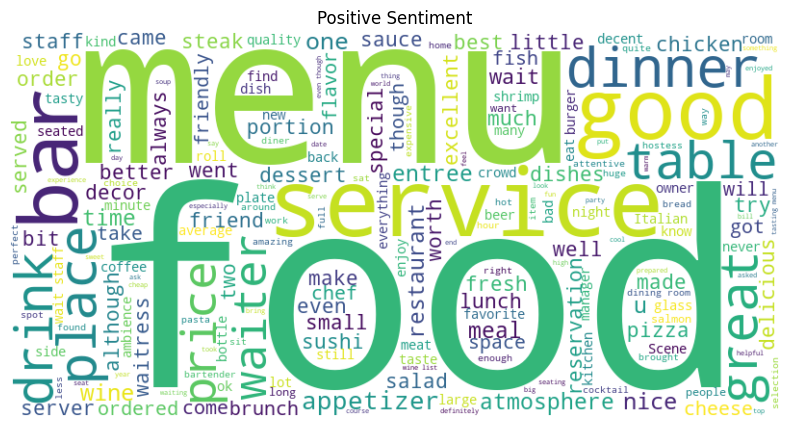

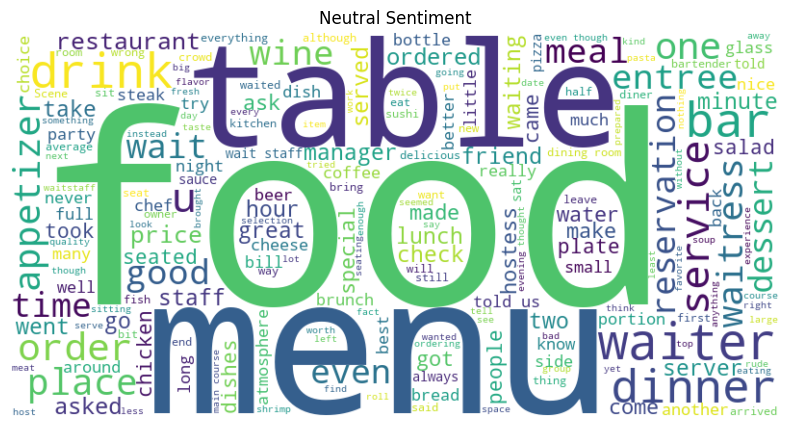

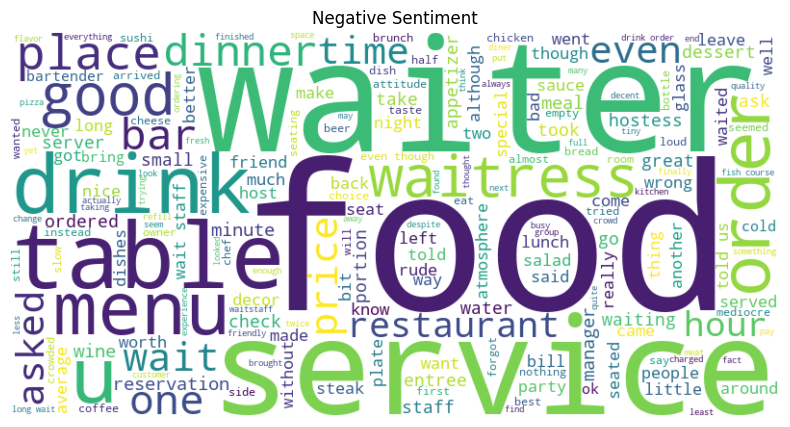

In [ ]:
for sentiment in df["label"].unique():
    sentiment_text = df[df["label"] == sentiment]["text"].dropna()
    generate_wordcloud(
        sentiment_text,
        f"{sentiment.capitalize()} Sentiment",
        f"{sentiment}_sentiment_wordcloud.png",
    )

## n-gram analysis


In [ ]:
def get_top_ngrams(corpus, ngram_range, n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
corpus = df["text"].dropna()
top_bigrams = get_top_ngrams(corpus, ngram_range=(2, 2))
top_trigrams = get_top_ngrams(corpus, ngram_range=(3, 3))

In [114]:
print("Top 10 Bigrams:")
print(top_bigrams)
print("\nTop 10 Trigrams:")
print(top_trigrams)

Top 10 Bigrams:
[('wait staff', np.int64(287)), ('food good', np.int64(257)), ('dining room', np.int64(209)), ('food service', np.int64(188)), ('15 minutes', np.int64(157)), ('long wait', np.int64(137)), ('long time', np.int64(129)), ('wine list', np.int64(124)), ('10 minutes', np.int64(119)), ('20 minutes', np.int64(109))]

Top 10 Trigrams:
[('took 15 minutes', np.int64(38)), ('manager came table', np.int64(33)), ('waitress came table', np.int64(29)), ('wait staff attentive', np.int64(28)), ('service little slow', np.int64(27)), ('main dining room', np.int64(26)), ('food pretty good', np.int64(26)), ('waited 15 minutes', np.int64(25)), ('came table told', np.int64(25)), ('course tasting menu', np.int64(24))]


**Key Findings:**
- **Top Bigrams**: 
  - Service-related: "wait staff", "food service", "long wait"
  - Quality-related: "food good"
  - Location-related: "dining room"
  - Time-related: "15 minutes", "10 minutes", "20 minutes", "long time"
- **Top Trigrams**:
  - Service patterns: "took 15 minutes", "waited 15 minutes", "service little slow"
  - Interaction patterns: "manager came table", "waitress came table", "came table told"
  - Quality patterns: "food pretty good", "wait staff attentive"


## explore 'miscellaneous' aspect


In [ ]:
miscellaneous_df = df[df["aspect"] == "miscellaneous"]
miscellaneous_text = miscellaneous_df["text"].dropna()

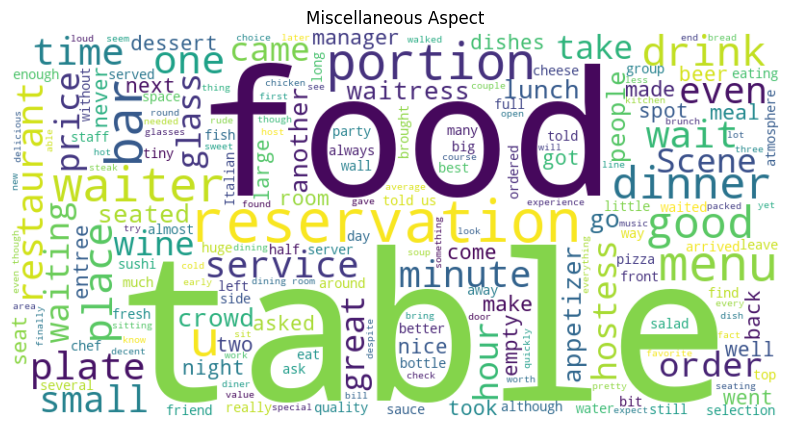

In [ ]:
generate_wordcloud(
    miscellaneous_text, "Miscellaneous Aspect", "miscellaneous_aspect_wordcloud.png"
)

In [117]:
for text in miscellaneous_df["text"].head():
    print(f"- {text}")

- Hostess was extremely accommodating when we arrived an hour early for our reservation.
- We were a couple of minutes late for our reservation and minus one guest, but we didn't think we deserved the attitude we got from the hostess.
- Although we arrived at the restaurant 10 min late, the hostess did not have a table for us.
- I like the smaller portion size for dinner.
- The bill was surprisingly inexpensive considering we each had appetizers, an entree, dessert and drinks (alcoholic and non) we also had 3 rounds of shots for the entire table.


**Key Findings:**
- The "miscellaneous" aspect captures aspects that don't fit into standard categories
- Examples include: hostess behavior, timing issues (arriving early/late), portion sizes, pricing/billing
- These are legitimate aspects but harder to categorize into predefined buckets

## Analyze 'neutral' sentiment


In [ ]:
neutral_df = df[df["label"] == "neutral"]

In [ ]:
for text in neutral_df["text"].head():
    print(f"- {text}")
print("-" * 30)
print(neutral_df["aspect"].value_counts().nlargest(10))

- It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you.
- Hostess was extremely accommodating when we arrived an hour early for our reservation.
- We were a couple of minutes late for our reservation and minus one guest, but we didn't think we deserved the attitude we got from the hostess.
- Although we arrived at the restaurant 10 min late, the hostess did not have a table for us.
- I like the smaller portion size for dinner.
------------------------------
aspect
food             1491
menu              688
miscellaneous     531
place             441
dinner            283
bar               261
price             176
drinks            162
service           149
table             142
Name: count, dtype: int64


**Key Findings:**
- Neutral sentiment examples show factual, descriptive statements without strong emotional indicators
- Top aspects for neutral sentiment: food (1491), menu (688), miscellaneous (531), place (441)
- Neutral reviews often describe facts rather than express opinions

**What to Understand:**
- **Sentiment Classification Challenge**:
  - Neutral sentiment is often the hardest to classify correctly
  - It requires distinguishing between factual statements and subtle opinions
  - Examples show neutral can include both positive-leaning ("best sit down food") and negative-leaning ("didn't deserve the attitude") statements

## Compare Train and Val


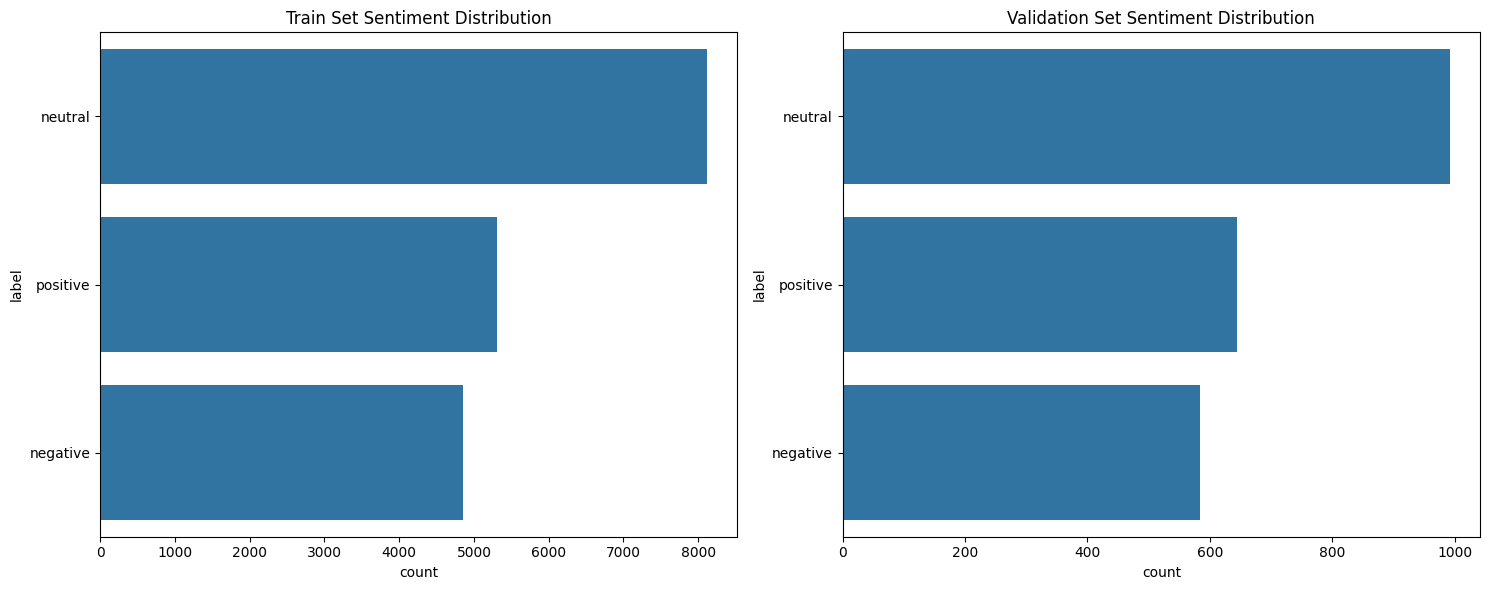

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(y="label", data=df, ax=axes[0], order=df["label"].value_counts().index)
axes[0].set_title("Train Set Sentiment Distribution")
sns.countplot(
    y="label", data=df_val, ax=axes[1], order=df_val["label"].value_counts().index
)
axes[1].set_title("Validation Set Sentiment Distribution")
plt.tight_layout()
plt.savefig("../plots/sentiment_distribution_comparison.png")


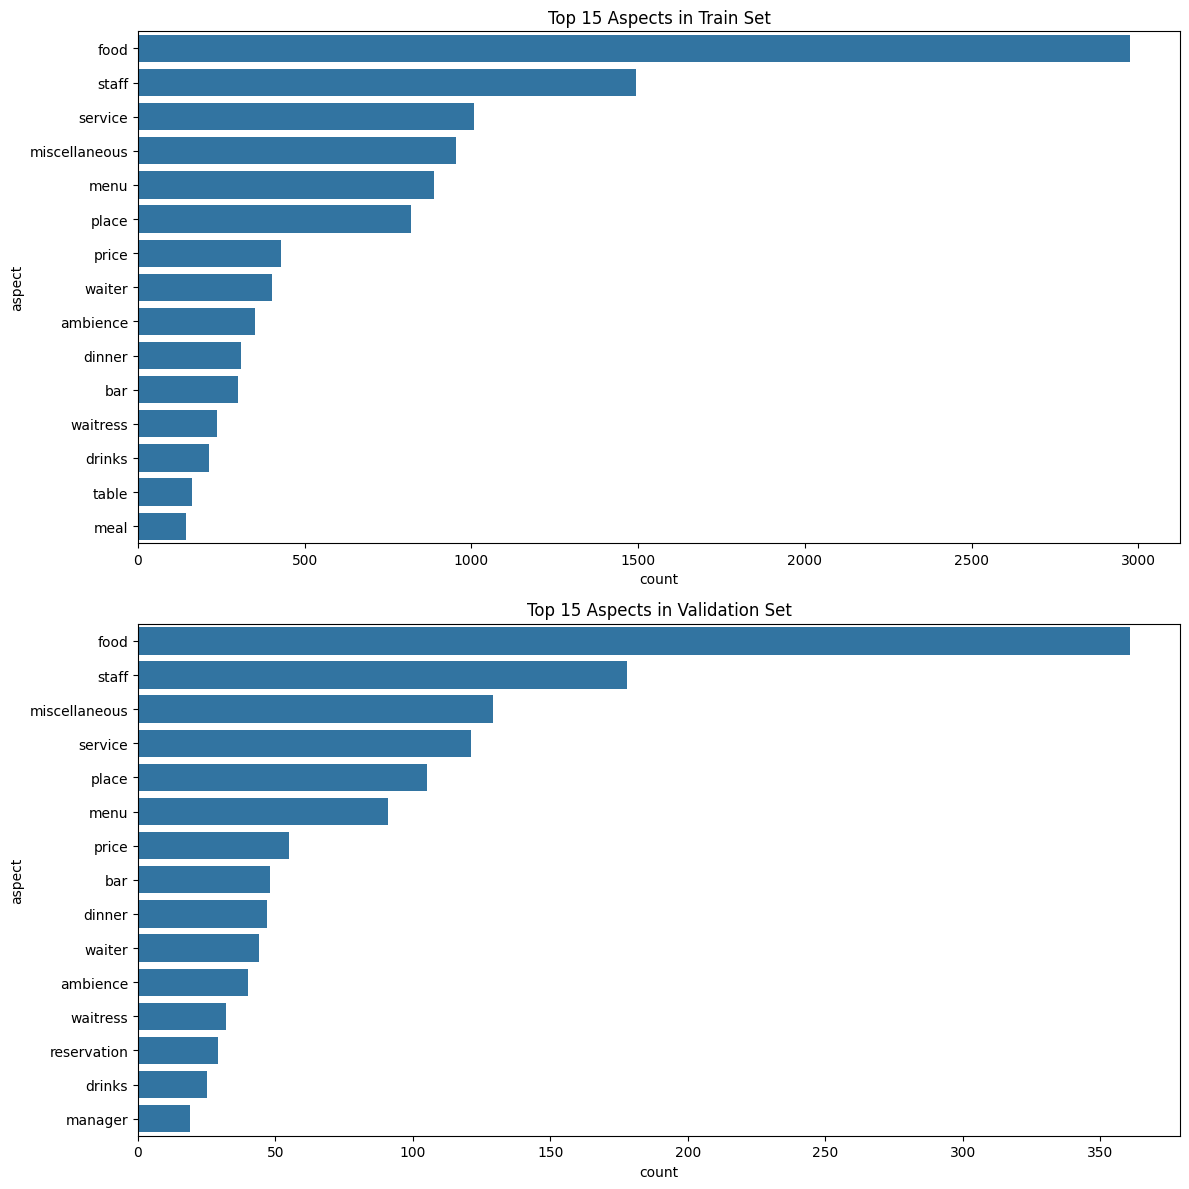

In [125]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
top_n_aspects = 15
train_top_aspects = df["aspect"].value_counts().nlargest(top_n_aspects).index
sns.countplot(
    y="aspect",
    data=df[df["aspect"].isin(train_top_aspects)],
    ax=axes[0],
    order=train_top_aspects,
)
axes[0].set_title(f"Top {top_n_aspects} Aspects in Train Set")
val_top_aspects = df_val["aspect"].value_counts().nlargest(top_n_aspects).index
sns.countplot(
    y="aspect",
    data=df_val[df_val["aspect"].isin(val_top_aspects)],
    ax=axes[1],
    order=val_top_aspects,
)
axes[1].set_title(f"Top {top_n_aspects} Aspects in Validation Set")
plt.tight_layout()
plt.savefig("../plots/aspect_distribution_comparison.png")

Top aspects in both train and validation sets are almost same and this is a sign of good split.

## Date Overview summary

quality of data is good, have a little duplicates with almost non nulls data, split between train and val data is almost the same, and from word cloud, the reviews are equal in sentiments in the same context.